In [11]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from contextlib import contextmanager
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, learning_curve
%matplotlib inline

In [13]:
def read_file(file):
    return pd.read_csv(f'data/{file}')

In [14]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

## Introduction
For this notebook, I only investigated the application dataset, ignoring the other 6 tables.
<br>
In the end of the notebook, I built a Logistic Regression model as a baseline for future research.

## Application Data

In [15]:
application = read_file('application.csv')

In [5]:
print(f'Size of application: {application.shape}')
application.head()

Size of application: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
application_label = application['TARGET']
application_features = application.drop(['SK_ID_CURR', 'TARGET'], axis=1)
print(f'Size of labels: {application_label.shape}')
print(f'Size of features: {application_features.shape}')

Size of labels: (307511,)
Size of features: (307511, 120)


## Distribution of Label

In [7]:
application_label.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Notice that the label is unbalanced. There are far more loans were repaid than defaulted

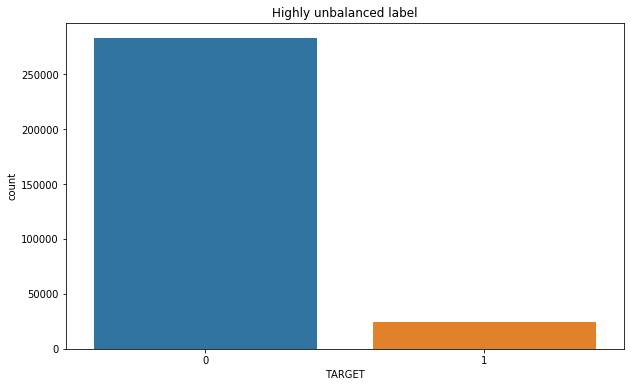

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(application_label).set_title('Highly unbalanced label')
plt.show()

## Missing Value

In [9]:
def show_missing_val(df):
    missing_val = df.isna().sum()
    missing_val_pct = round(df.isna().sum() / len(df) * 100, 1)
    missing_val_df = pd.concat([missing_val, missing_val_pct], axis=1)
    missing_val_df.rename(columns={0: 'missing', 1: 'missing_pct'}, inplace=True)
    missing_val_df = missing_val_df[missing_val_df['missing'] != 0]
    print(f'{len(missing_val_df)} out of {len(df.columns)} columns have missing values.')
    missing_numeric_col = []
    for col in df:
        if df[col].dtype != 'object' and col in missing_val_df.index:
            missing_numeric_col.append(col)
    print(f'{len(missing_numeric_col)} numeric features have missing value:\n{missing_numeric_col}')
    return missing_val_df.sort_values('missing', ascending=False)

In [10]:
show_missing_val(application_features)

67 out of 120 columns have missing values.
61 numeric features have missing value:
['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', '

,missing,missing_pct
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


## Anomalies
I have investigated features such as age and length of employment to see if there are obvious error values.

In [62]:
(application_features['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [64]:
-application_features['DAYS_EMPLOYED'].describe()

count   -307511.000000
mean     -63815.045904
std     -141275.766519
min       17912.000000
25%        2760.000000
50%        1213.000000
75%         289.000000
max     -365243.000000
Name: DAYS_EMPLOYED, dtype: float64

The maximum days employed looks not right, this is about 1000 years.

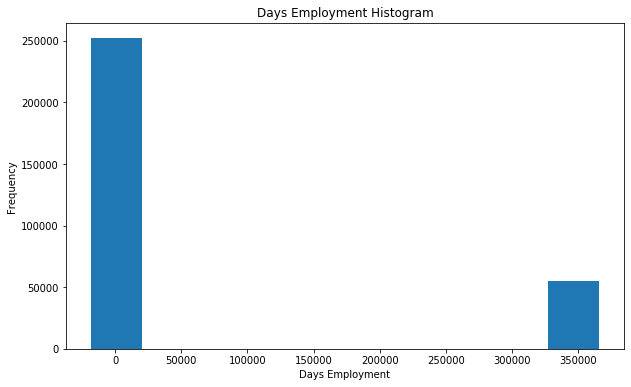

In [65]:
plt.figure(figsize=(10, 6))
application_features['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment'); 
plt.show()

We can handle the anomalies by filling them with NaN, and create a binary column indicating if this is an anomaly.

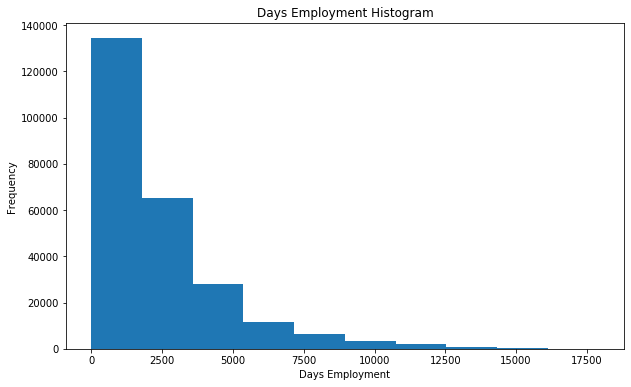

In [17]:
application_features['DAYS_EMPLOYED_ANOM'] = application_features["DAYS_EMPLOYED"] == 365243
# Replace the anomalous values with nan
application_features['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
plt.figure(figsize=(10, 6))
(-application_features['DAYS_EMPLOYED']).plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment');

Now, the employment days look resonable.

## Train Test Split
Create a training (80%) and a testing set (20%), the test set will be used for evaluating the model's out-of-sample predicting power.

In [19]:
def df_train_test_split(feature, label, train_size=0.8, random_state=55):
    train_features = feature.sample(frac=train_size, random_state=random_state)
    train_label = label[train_features.index]
    test_features = feature.iloc[~feature.index.isin(train_features.index), :]
    test_label = label[~label.index.isin(train_features.index)]
    return train_features, train_label, test_features, test_label

In [20]:
application_train_features, application_train_label, application_test_features, application_test_label = \
    df_train_test_split(application_features, application_label)

## Preparing for Training
### Categorical Varibles Encoding

In [21]:
application_train_features = pd.get_dummies(application_train_features, drop_first=True)
application_test_features = pd.get_dummies(application_test_features, drop_first=True)

print('Training Features shape: ', application_train_features.shape)
print('Testing Features shape: ', application_test_features.shape)

Training Features shape:  (246009, 229)
Testing Features shape:  (61502, 228)


Align the training and testing data, keep only columns present in both dataframes.

In [22]:
application_train_features, application_test_features = \
    application_train_features.align(application_test_features, join='inner', axis=1)

print('Training Features shape: ', application_train_features.shape)
print('Testing Features shape: ', application_test_features.shape)

Training Features shape:  (246009, 228)
Testing Features shape:  (61502, 228)


## Baseline Model: Logistic Regression
I created a pipeline to simplify the modeling process:
>- Use median to fill missing value so that it is robust to outliers.
>- Scale the data with MinMaxScaler
>- Fit Logistic Regression Model, we set penalty to 0.001 to help converge and class_weight to balanced to handel unbalanced label

In [23]:
pipe = Pipeline([('impute', SimpleImputer(strategy = 'median')), 
                 ('scaler', MinMaxScaler(feature_range = (0, 1))), 
                 ('logit', LogisticRegression(C = 0.001, class_weight='balanced'))])
X_train, y_train = application_train_features.to_numpy(), application_train_label.to_numpy()
X_test, y_test = application_test_features.to_numpy(), application_test_label.to_numpy()
print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)
pipe.fit(X_train, y_train)
joblib.dump(pipe, 'Models/Logistic_Regression_base.md')

Training data shape:  (246009, 228)
Testing data shape:  (61502, 228)


['Logistic_Regression_base.md']

In [146]:
def cross_validate(model, label, folds=10, X=X_train, y=y_train):
    print(f'{folds}-fold cross validation scores:\n')
    scores = cross_val_score(model, X, y, cv=folds, scoring='roc_auc')
    print("roc_auc: %0.3f [%s]" % (scores.mean(), label))

In [152]:
with timer('Cross Validation'):
    cross_validate(pipe, 'Logistic Regression')

10-fold cross validation scores:

roc_auc: 0.74 [Logistic Regression]
Cross Validation - done in 125s


In [181]:
def display_learning_curve(model, X, y, title, axes=None, ylim=None, cv=10, scoring='roc_auc', 
                           train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    train_sizes, train_scores, valid_scores, fit_times, _  = \
        learning_curve(model, X, y, cv=cv, train_sizes=train_sizes, 
                       scoring=scoring, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label=f"Training {scoring}")
    axes[0].plot(train_sizes, valid_scores_mean, 'o-', color="g",
                 label=f"Cross-validation {scoring}")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, valid_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")

    return plt


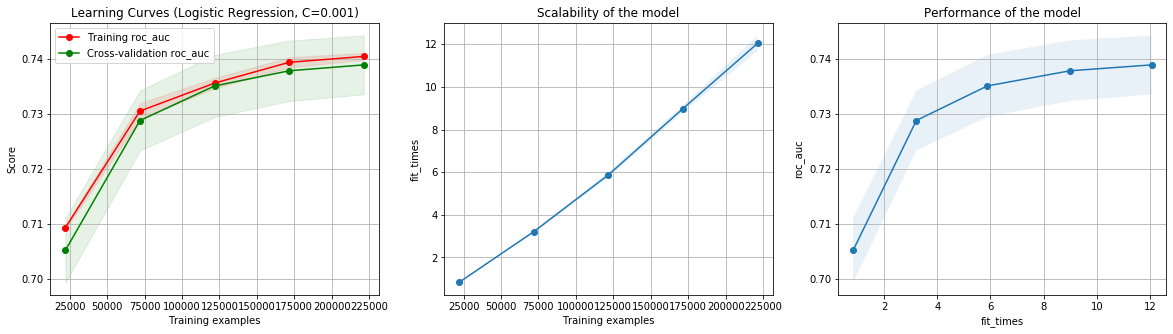

Display Learning Curve - done in 386s


In [182]:
with timer('Display Learning Curve'):
    title = r"Learning Curves (Logistic Regression, C=0.001)"
    display_learning_curve(pipe, X_train, y_train, title)
    plt.show()

In [177]:
def evaluate(model, X_test, y_test):
    print(model[2], '\n')
    title = r"Learning Curves (Logistic Regression, C=0.001)"
    display_learning_curve(pipe, X_train, y_train, title)
    y_predict = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_predict)
    cr = classification_report(y_test, y_predict, target_names=['Repaid', 'Default'], digits=3)
    print('Out-of-Sample Performance:\n')
    print(cr)
    print(f'roc_auc: {roc_auc}\n')
    print(f'Confusion Matrix:\n')
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

LogisticRegression(C=0.001, class_weight='balanced') 

Out-of-Sample Performance:

              precision    recall  f1-score   support

      Repaid      0.960     0.682     0.798     56559
     Default      0.157     0.679     0.255      4943

    accuracy                          0.682     61502
   macro avg      0.559     0.680     0.526     61502
weighted avg      0.896     0.682     0.754     61502

roc_auc: 0.6804236518879272

Confusion Matrix:



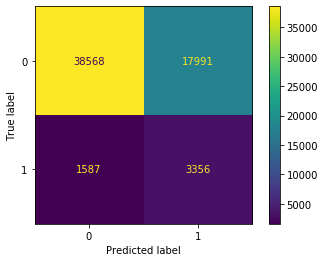

Evaluate Model Performance - done in 1s


In [178]:
with timer('Evaluate Model Performance'):
    evaluate(pipe, X_test, y_test)

## Conclusion

The base Logistic Regression has a cross validation score of 0.74 and a out-of-sample roc of 0.68 which is not too bad. I will be doing a more in-depth EDA on the application data and the other 6 tables to see if I can boost the roc score. I will also fit a random forest model in the next notebook.

## Combining Some functions

I have put the preprocessing and evaluating steps into functions to simplify next research, the function will be stored in helper_functions.py